This notebook is aimed at summarzing the REPET output at different levels of the nomenclature and to plot this out. Parts of it are really slow.


This notebook was only designed for the purpose of analyzing the Pst-104E genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    This function expects that the variable genome either ends with p_ctg or h_ctg and adapts the
    search pattern accordingly.
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        if genome.endswith('p_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)'
        elif genome.endswith('h_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        if genome.endswith('p_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        elif genome.endswith('h_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        if genome.endswith('p_ctg'):
            blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        elif genome.endswith('h_ctg'):
             blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [3]:
def blast_hit_gff(_feature, _row8, _id):
    """
    This filter parses the blast hit for REPET_TEs from the new 'ID' column. If no blast hit available returns Pastec ids.
    If the result is blast already the value is simple parse the blast hit.
    SSRs also get SSR
    !!!Requires the three_letter_dict to be defined previously.!!!
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the pastec_cat into the first three letter code
        #the spliting of the 'ID' column needs to be done differently depending on the h or p contigs.
        #h contigs contain one additional '_' in the contig id

        pastec_cat = _id.split('_')[0]
        if 'TE_BLR' in _row8:
            #hit_list = [x.split(';')[3] for x in _row8]
            blast_hit_pattern = r'TE_BLR\w*: (\S*)[ |;]'
            blast_hit_prog = re.compile(blast_hit_pattern)
            TE_match = blast_hit_prog.findall(_row8)
            first_sub_class = ':'.join(TE_match[0][:-1].split(':')[1:])
            if len([x for x in TE_match if first_sub_class in x]) == len(TE_match):
                if ';' in first_sub_class:
                    return first_sub_class.split(';')[0]
                else:
                    return first_sub_class
#fix this here to include the there letter code of the first bit of the ID similar to the blast hits
#e.g. ClassI:?:? and so on. a dict might be the easiest here.
            
            else:
                return three_letter_dict[pastec_cat]
        else:
            return three_letter_dict[pastec_cat]
    if _type == 'REPET_SSRs':
        return 'SSR'
        

        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        return ':'.join(_id.split(':')[1:])

In [4]:
def TE_classification_filter(_id, level = 0):
    """
    This function pulls out the class == level1, Order == level2, Superfamily == leve3.
    If SSR or noCat return these values.
    
    """
    if len(_id.split(':')) == 1:
        return _id
    if level == 0:
        _class = _id.split(':')[0]
        if _class == 'ClassI':
            return 'Retrotransposon'
        if _class == 'ClassII':
            return 'DNA_transposon'
    elif level == 1:
        _order = _id.split(':')[1]
        if _order == '?':
            return 'noCat'
        else:
            return _order
    elif level == 2:
        _superfamily = _id.split(':')[2]
        if _superfamily == '?':
            return 'noCat'
        else:
            return _superfamily
    else:
        print('Something wrong! Check if level is 0, 1 or 2')

#### This needs to be updated here according to genome (either p_ctg or h_ctg)

In [5]:
source_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'


genome = 'Pst_104E_v12_h_ctg'

out_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis'

In [6]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [7]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.REPET.gff > {out_dir}/{genome}.REPET.gff

In [8]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

#### This needs to be updated here according to genome

In [9]:
#This needs to be updated here according to genome
TE_post_analysis_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/REPET/Pst79_a/Pst79a_full_annotate/postanalysis/'

In [10]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [11]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [12]:
!ls {TE_post_analysis_p}

_blastclust.classifStatsPerCluster.tab
blastclust.log
error.log
Pst79a_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab
Pst79a_anno_chr_allTEs_nr_noSSR_join_path.globalAnnotStatsPerTE.txt
Pst79a_anno_chr_allTEs_path.annotStatsPerCluster.tab
Pst79a_anno_chr_allTEs_path.annotStatsPerTE.tab
Pst79a_anno_chr_allTEs_path.globalAnnotStatsPerTE.txt
Pst79a_anno_refTEs.fa
Pst79a_anno_refTEs.fa_blastclust.classifStatsPerCluster.tab
Pst79a_anno_refTEs.fa_blastclust.globalStatsPerCluster.txt
Pst79a_anno_refTEs.fa_blastclust.statsPerCluster.tab
Pst79a_anno_refTEs.fa_blastclust.tab


In [13]:
#this needs to be fixed up to pick the proper summary table
p_repet_summary_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79a_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#check if I can filter the tab files for removing all TEs that are on the 2000 plus contigs
#remove tRNAs TEs with infernal

p_repet_summary_df['Code'] = p_repet_summary_df['TE'].apply(lambda x: x.split('_')[0])

code_keys = p_repet_summary_df['Code'].unique()

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon LARD', 'Retrotransposon LARD',\
              'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon DIRS',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']
if len(code_keys) != len(code_long):
    print('Check the code_long list, because different length of keys and values!\n\n')
else:
    print('Check the code dict anyway')
code_dict = dict(zip(code_keys, code_long))
print(code_dict)

Check the code dict anyway
{'RIX-incomp-chim': 'Retrotransposon LINE', 'RYX-comp-chim': 'Retrotransposon DIRS', 'DTX-incomp': 'DNA_transposon TIR', 'RIX-incomp': 'Retrotransposon LINE', 'DMX-incomp': 'DNA_transposon Maverick', 'RSX-incomp-chim': 'Retrotransposon SINE', 'DTX-comp-chim': 'DNA_transposon TIR', 'RPX-incomp-chim': 'Retrotransposon PLE', 'PotentialHostGene': 'Potential Host Gene', 'RLX-incomp-chim': 'Retrotransposon LTR', 'XXX-chim': 'noCat', 'RYX-incomp-chim': 'Retrotransposon DIRS', 'RXX-TRIM': 'Retrotransposon TRIM', 'RXX-LARD-chim': 'Retrotransposon LARD', 'RYX-incomp': 'Retrotransposon DIRS', 'RLX-comp-chim': 'Retrotransposon LTR', 'DHX-comp': 'DNA_transposon Helitron', 'DHX-incomp': 'DNA_transposon Helitron', 'DTX-incomp-chim': 'DNA_transposon TIR', 'DXX-MITE-chim': 'DNA_transposon MITE', 'DXX-MITE': 'DNA_transposon MITE', 'DXX': 'DNA_transposon noCat', 'RSX-incomp': 'Retrotransposon SINE', 'DHX-incomp-chim': 'DNA_transposon Helitron', 'RXX-TRIM-chim': 'Retrotransposon

In [14]:
p_repet_summary_df['Code long'] = p_repet_summary_df['Code'].apply(lambda x: code_dict[x])
p_repet_summary_sum_df = pd.pivot_table(p_repet_summary_df, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)
p_repet_summary_mean_df = pd.pivot_table(p_repet_summary_df, values='length', index='Code long', aggfunc=np.mean)
pd.concat([p_repet_summary_sum_df,p_repet_summary_mean_df], axis=1 )

,copies,covg,length
Code long,,,
DNA_transposon Helitron,1066,958602,5340.676471
DNA_transposon MITE,4657,1202450,474.118644
DNA_transposon Maverick,292,494044,11855.200000
DNA_transposon TIR,15967,10441285,3930.630588
DNA_transposon noCat,4938,2190119,3223.552000
Potential Host Gene,1156,820654,4680.804348
Retrotransposon DIRS,1248,967757,6579.875000
Retrotransposon LARD,7663,3867625,5396.531073
Retrotransposon LINE,393,234467,3518.909091


#### This needs to be updated here according to genome

In [15]:
#now filter the gff dataframe to delete all the high coverage contigs
#This might would have to be fixed as well. If we don't delete it as files should be already filtered
contigs_smaller_2000 = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly/hcontig_smaller_2000.txt',\
                                  header=None)[0].tolist()

p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

p_repet_gff_filtered = p_repet_gff[p_repet_gff[0].isin(contigs_smaller_2000)].reset_index(drop=True)

In [16]:
#filter out potential host genes
p_repet_gff_filtered = p_repet_gff_filtered[~p_repet_gff_filtered[8].str.contains("Potential")]

In [17]:
p_repet_gff_filtered['ID'] = p_repet_gff_filtered.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [24]:
#re-generate the code dict using the gff ID as Code keys


code_keys_gff = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('REPET_TE')]['ID'].unique()

code_keys_gff = list({x.split('_')[0] for x in code_keys_gff})

code_keys_gff.sort()

#remove Potential host genes from long code list as those were filtered out previously.
#code_long.remove('Potential Host Gene')

if len(code_keys_gff) != len(code_long):
    print("Go and check something is wrong at the code key stage!")

code_dict = dict(zip(code_keys_gff, code_long))

In [25]:
three_letter_code = list({x for x in code_keys_gff})

three_letter_code.sort()

three_letter_values = []
for x in three_letter_code:
    if 'MITE' in x:
        _value = "ClassII:MITE:?"
        three_letter_values.append(_value)
        continue
    if 'LARD' in x:
        _value = 'ClassI:LARD:?'
        three_letter_values.append(_value)
        continue
    if 'TRIM' in x:
        _value = 'ClassI:TRIM:?'
        three_letter_values.append(_value)
        continue
    _value =''
    if x[0] == 'D':
        _value = _value + 'ClassII:'
    if x[0] == 'R':
        _value = _value + 'ClassI:'
    if x[0] != 'D' and x[0] != 'R':
        _value = 'noCat'
        three_letter_values.append(_value)
        continue
    if x[1] == 'T':
        _value = _value + 'TIR:?'
    if x[1] == 'H':
        _value = _value + 'Helitron:?'
    if x[1] == 'M':
        _value = _value + 'Maverick:?'
    if x[0:2] == 'DY':
        _value = _value + ':Crypton:?'
    if x[1] == 'X':
        _value = _value + '?:?'
    if x[1] == 'I':
        _value = _value + 'LINE:?'
    if x[1] == 'L':
        _value = _value + 'LTR:?'
    if x[1] == 'P':
        _value = _value + 'Penelope:?'
    if x[1] == 'S':
        _value = _value + 'SINE:?'
    if x[0:2] == 'RY':
        _value = _value + 'DIRS:?'    
    three_letter_values.append(_value)

if len(three_letter_code) == len(three_letter_values):
    print("Aas")
    three_letter_dict = dict(zip(three_letter_code, three_letter_values))

Aas


In [26]:
three_letter_dict

{'DHX-comp': 'ClassII:Helitron:?',
 'DHX-incomp': 'ClassII:Helitron:?',
 'DHX-incomp-chim': 'ClassII:Helitron:?',
 'DMX-incomp': 'ClassII:Maverick:?',
 'DTX-comp': 'ClassII:TIR:?',
 'DTX-comp-chim': 'ClassII:TIR:?',
 'DTX-incomp': 'ClassII:TIR:?',
 'DTX-incomp-chim': 'ClassII:TIR:?',
 'DXX': 'ClassII:?:?',
 'DXX-MITE': 'ClassII:MITE:?',
 'DXX-MITE-chim': 'ClassII:MITE:?',
 'RIX-comp': 'ClassI:LINE:?',
 'RIX-incomp': 'ClassI:LINE:?',
 'RIX-incomp-chim': 'ClassI:LINE:?',
 'RLX-comp': 'ClassI:LTR:?',
 'RLX-comp-chim': 'ClassI:LTR:?',
 'RLX-incomp': 'ClassI:LTR:?',
 'RLX-incomp-chim': 'ClassI:LTR:?',
 'RPX-incomp-chim': 'ClassI:Penelope:?',
 'RSX-incomp': 'ClassI:SINE:?',
 'RSX-incomp-chim': 'ClassI:SINE:?',
 'RXX-LARD': 'ClassI:LARD:?',
 'RXX-LARD-chim': 'ClassI:LARD:?',
 'RXX-TRIM': 'ClassI:TRIM:?',
 'RXX-TRIM-chim': 'ClassI:TRIM:?',
 'RYX-comp': 'ClassI:DIRS:?',
 'RYX-comp-chim': 'ClassI:DIRS:?',
 'RYX-incomp': 'ClassI:DIRS:?',
 'RYX-incomp-chim': 'ClassI:DIRS:?',
 'XXX-chim': 'noCat',


In [27]:
p_repet_gff_filtered['Class:Order:Superfamily'] = p_repet_gff_filtered.apply(lambda row: blast_hit_gff(row[1], row[8], row['ID']), axis=1)

In [28]:
#generate a dict that can be used to rename the Class:Order:Superfamily column considering that partial matches ([2] == match_part) might contain different
#IDs even though they are the same TE only partial.
_tmp_subset = p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

TE_COS_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

_tmp_subset = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

_tmp_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

TE_COS_dict.update(_tmp_dict)
#remove all backslashes from the values as this will conflict with the output later on
for x in TE_COS_dict.keys():
    if '/' in TE_COS_dict[x]:
        value = TE_COS_dict[x]
        print(value)
        TE_COS_dict[x] = value.replace('/','_')
        print(TE_COS_dict[x])

In [30]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.long.df', sep='\t', header = None, index=None)

In [31]:
p_repet_gff_filtered['Class:Order:Superfamily'] = p_repet_gff_filtered['ID'].apply(lambda x: TE_COS_dict[x])

In [32]:
print('These are the unique Class:Order:Superfamily classifiers of this dataframe:')
print(p_repet_gff_filtered['Class:Order:Superfamily'].unique())

These are the unique Class:Order:Superfamily classifiers of this dataframe:
['ClassII:TIR:MuDR' 'ClassII:TIR:PIF-Harbinger' 'ClassII:TIR:CACTA'
 'ClassII:TIR:Tc1-Mariner' 'ClassII:?:?' 'ClassI:LTR:Copia'
 'ClassI:LTR:Gypsy' 'ClassII:TIR:hAT' 'ClassI:LARD:?' 'ClassII:MITE:?'
 'ClassI:LTR:?' 'ClassII:TIR:?' 'SSR' 'ClassII:Helitron:?' 'ClassII:TIR:P'
 'ClassI:LINE:I' 'noCat' 'ClassI:DIRS:?' 'ClassI:TRIM:?' 'ClassI:DIRS:DIRS'
 'ClassII:Helitron:Helitron' 'ClassII:Maverick:?' 'ClassI:Penelope:?'
 'ClassI:LINE:Jockey' 'ClassI:LTR:ERV' 'ClassII:?:Academ'
 'ClassII:?:Ginger1' 'ClassI:LTR:Retrovirus' 'ClassI:SINE:?' 'ClassI:?:?'
 'ClassII:?:Sola' 'ClassI:LINE:?' 'ClassI:LTR:Bel-Pao' 'ClassI:LINE:L1'
 'ClassI:LINE:RTE' 'ClassI:PLE:Penelope' 'ClassII:?:Novosib'
 'ClassII:Maverick:Maverick' 'ClassI:LINE:R2' 'ClassII:TIR:PiggyBac'
 'ClassII:Crypton:Crypton' 'ClassII:?:Kolobok' 'ClassII:TIR:Transib']


In [33]:
#have a rough summary of the coverage not considering overlaps.
p_repet_gff_filtered.drop_duplicates(subset=[3,4,'ID'], inplace =True)
p_repet_gff_filtered['Length'] = p_repet_gff_filtered[4] - p_repet_gff_filtered[3]
p_repet_gff_filtered['Class'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
p_repet_gff_filtered['Order'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
p_repet_gff_filtered['Superfamily'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
p_repet_gff_len_COS = p_repet_gff_filtered.groupby(by=['Class','Order','Superfamily'])['Length'].sum()
p_repet_gff_len_S = p_repet_gff_filtered.groupby(by=['Class:Order:Superfamily'])['Length'].sum()

In [34]:
print("This is the summary of overlapping coverage according to Class, Order, Superfamily")
print(p_repet_gff_len_COS)

This is the summary of overlapping coverage according to Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton               441
                 Helitron  Helitron          1383771
                           noCat              815935
                 MITE      noCat             1472248
                 Maverick  Maverick             5065
                           noCat              648632
                 TIR       CACTA             1531452
                           MuDR              4277001
                           P                  296641
                           PIF-Harbinger     3896830
                           PiggyBac              345
                           Tc1-Mariner       3051914
                           Transib               755
                           hAT               7406408
                           noCat             2943453
                 noCat     Academ            1871539
                           G

In [35]:
print("This is the summary of overlapping coverage according to Superfamily")
print(p_repet_gff_len_S)

This is the summary of overlapping coverage according to Superfamily
Class:Order:Superfamily
ClassI:?:?                      46274
ClassI:DIRS:?                  370767
ClassI:DIRS:DIRS               973658
ClassI:LARD:?                 2679250
ClassI:LINE:?                   48642
ClassI:LINE:I                  653747
ClassI:LINE:Jockey              63988
ClassI:LINE:L1                   1303
ClassI:LINE:R2                   4172
ClassI:LINE:RTE                  2131
ClassI:LTR:?                  2658233
ClassI:LTR:Bel-Pao               6194
ClassI:LTR:Copia             10996425
ClassI:LTR:ERV                 112073
ClassI:LTR:Gypsy             23520311
ClassI:LTR:Retrovirus            4823
ClassI:PLE:Penelope              5944
ClassI:Penelope:?               85719
ClassI:SINE:?                   17558
ClassI:TRIM:?                  114928
ClassII:?:?                   6495090
ClassII:?:Academ              1871539
ClassII:?:Ginger1                3049
ClassII:?:Kolobok                

In [36]:
num_unique_TEs = len(p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')]['ID'].unique())
num_unique_TE_super = len(p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')]['Class:Order:Superfamily'].unique())

print('This is the number of unique TEs: %i\nThis is the number of unique TE superfamilies: %i' % (num_unique_TEs, num_unique_TE_super))

This is the number of unique TEs: 12180
This is the number of unique TE superfamilies: 42


In [37]:
p_repet_gff_filtered.groupby(by=['Class','Order','Superfamily'])['Length'].count() 


Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton              3
                 Helitron  Helitron          2945
                           noCat              813
                 MITE      noCat             5028
                 Maverick  Maverick             9
                           noCat              352
                 TIR       CACTA             2442
                           MuDR              8394
                           P                  852
                           PIF-Harbinger     9335
                           PiggyBac             3
                           Tc1-Mariner       7699
                           Transib              4
                           hAT              17914
                           noCat             4344
                 noCat     Academ            2637
                           Ginger1             35
                           Kolobok              1
                           Novosib              2
         

In [38]:
p_repet_gff_filtered.groupby(by=['Class:Order:Superfamily'])['Length'].count()

Class:Order:Superfamily
ClassI:?:?                     129
ClassI:DIRS:?                  449
ClassI:DIRS:DIRS              2278
ClassI:LARD:?                 4067
ClassI:LINE:?                  112
ClassI:LINE:I                 1514
ClassI:LINE:Jockey             290
ClassI:LINE:L1                  14
ClassI:LINE:R2                  11
ClassI:LINE:RTE                 24
ClassI:LTR:?                  5741
ClassI:LTR:Bel-Pao              39
ClassI:LTR:Copia             30203
ClassI:LTR:ERV                1256
ClassI:LTR:Gypsy             61896
ClassI:LTR:Retrovirus           47
ClassI:PLE:Penelope             27
ClassI:Penelope:?               86
ClassI:SINE:?                  120
ClassI:TRIM:?                  273
ClassII:?:?                  21417
ClassII:?:Academ              2637
ClassII:?:Ginger1               35
ClassII:?:Kolobok                1
ClassII:?:Novosib                2
ClassII:?:Sola                  14
ClassII:Crypton:Crypton          3
ClassII:Helitron:?             

In [39]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.long_v2.df', sep='\t', header = None, index=None)

In [40]:
#make new gff files where the ID column is the superfamily level
p_repet_gff_superfamily = p_repet_gff_filtered.iloc[:,:]
p_repet_gff_superfamily[8] = p_repet_gff_superfamily['Class:Order:Superfamily']
p_repet_gff_superfamily.iloc[:,0:9].to_csv(out_dir+'/'+genome+'.REPET.superfamily.gff', sep='\t', header = None, index=None,columns=None)

In [41]:
#make new gff file where the ID column is the TE level
p_repet_gff_TE = p_repet_gff_filtered.iloc[:,:]
p_repet_gff_TE[8] = p_repet_gff_TE['ID']
p_repet_gff_TE.iloc[:,0:9].to_csv(out_dir+'/'+genome+'.REPET.TE.gff', sep='\t', header = None, index=None,columns=None)

In [42]:
#generate the directory structure to safe specific coverage files
os.chdir(out_dir)
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [43]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id, bed_object, repet_prefix):
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id == 'noCat':
        out_path = TE_path_dict['noCat']
    #everything without '_' at the end should be SSR
    elif _id == 'SSR':
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = bed_object.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [44]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [51]:
repet_prefix_TE = genome+'.REPET.TE'
repet_prefix_S = genome+'.REPET.superfamily'
p_genome_file = genome+'.genome_file'
genome_df = pd.read_csv(p_genome_file, sep='\t', header=None,names=['contig', 'length'])

genome_size = genome_df['length'].sum()

In [50]:
#pull in the classification gff, make classification array, loop over array to save all the cov_dataframes
RE_TE_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.TE.gff')
g_TE = RE_TE_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.TE.bedobject')
#use the blast filtered dataframe as well
RE_S_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.superfamily.gff')
g_S = RE_S_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.superfamily.bedobject')

In [49]:
#use simple loop to loop over the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = g_S
superfamilies = p_repet_gff_superfamily['Class:Order:Superfamily'].unique()
for superfamily in superfamilies:
    subset_id(superfamily, bed_file, repet_prefix_S)
    print('Doing %s' % superfamily)

Doing ClassII:TIR:MuDR
Doing ClassII:TIR:PIF-Harbinger
Doing ClassII:TIR:CACTA
Doing ClassII:TIR:Tc1-Mariner
Doing ClassII:?:?
Doing ClassI:LTR:Copia
Doing ClassI:LTR:Gypsy
Doing ClassII:TIR:hAT
Doing ClassI:LARD:?
Doing ClassII:MITE:?
Doing ClassI:LTR:?
Doing ClassII:TIR:?
Doing SSR
Doing ClassII:Helitron:?
Doing ClassII:TIR:P
Doing ClassI:LINE:I
Doing noCat
Doing ClassI:DIRS:?
Doing ClassI:TRIM:?
Doing ClassI:DIRS:DIRS
Doing ClassII:Helitron:Helitron
Doing ClassII:Maverick:?
Doing ClassI:Penelope:?
Doing ClassI:LINE:Jockey
Doing ClassI:LTR:ERV
Doing ClassII:?:Academ
Doing ClassII:?:Ginger1
Doing ClassI:LTR:Retrovirus
Doing ClassI:SINE:?
Doing ClassI:?:?
Doing ClassII:?:Sola
Doing ClassI:LINE:?
Doing ClassI:LTR:Bel-Pao
Doing ClassI:LINE:L1
Doing ClassI:LINE:RTE
Doing ClassI:PLE:Penelope
Doing ClassII:?:Novosib
Doing ClassII:Maverick:Maverick
Doing ClassI:LINE:R2
Doing ClassII:TIR:PiggyBac
Doing ClassII:Crypton:Crypton
Doing ClassII:?:Kolobok
Doing ClassII:TIR:Transib


In [52]:
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    print(file)
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class:Order:Superfamily"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same superfamily
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+ repet_prefix_S +'.cov', sep='\t', header =None, index=None)

cov_per_superfamily = df_REPET_classification.pivot_table(values=1, columns= "Class:Order:Superfamily", aggfunc='count')
cov_per_contig_per_superfamily = df_REPET_classification.groupby([0, "Class:Order:Superfamily"])[1].count()

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ctg.REPET.superfamily.ClassII:?:?.cov
ClassII:?:?
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ctg.REPET.superfamily.ClassII:?:Academ.cov
ClassII:?:Academ
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ctg.REPET.superfamily.ClassII:?:Ginger1.cov
ClassII:?:Ginger1
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ctg.REPET.superfamily.ClassII:?:Kolobok.cov
ClassII:?:Kolobok
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ctg.REPET.superfamily.ClassII:?:Novosib.cov
ClassII:?:Novosib
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_h_ct

In [53]:
cov_all_TEs = df_REPET_classification.drop_duplicates([0,1]) #this gets ride of the overlap between different TE families and classes
cov_all_TEs = len(cov_all_TEs)

In [57]:

#make superfamily df and add columns for Class, order and superfamily
cov_per_superfamily_df = cov_per_superfamily.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))
cov_per_superfamily_df.rename(columns={0: 'bp'}, inplace=True)
cov_per_superfamily_df['%'] = cov_per_superfamily_df['bp']/genome_size*100
cov_per_superfamily_df['Class:Order:Superfamily'] = cov_per_superfamily_df.index

cov_per_superfamily_df['Class'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
cov_per_superfamily_df['Order'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
cov_per_superfamily_df['Superfamily'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
cov_per_superfamily_df.to_csv(out_dir+'/'+genome+'.REPET.summary.tab', sep='\t')

In [ ]:
#consider combining these cov data frames into classes and orders as well and simply using those as id column, drop duplicats 
#use those as real coverage analysis at those level

In [60]:
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class"] = file.split('.')[-2].split(':')[0] #parse out the Class from the file name
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Class
    df_list.append(tmp_df)
    print(file.split('.')[-2].split(':')[0])

df_REPET_classification_class = pd.concat(df_list)
df_REPET_classification_class.drop_duplicates(inplace=True)
df_REPET_classification_class.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Class') +'.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification_class.pivot_table(values=1, columns= "Class", aggfunc='count')
cov_per_contig_per_class = df_REPET_classification_class.groupby([0, "Class"])[1].count()

ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
SSR
noCat


In [61]:
#this parsing of of the order is neccessary to eliminate any overlap at the order level. See drop duplicates line 23.
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    if ':' in file:
        tmp_df["Order"] = ':'.join(file.split('.')[-2].split(':')[0:2]) #parse out the order from the file name
        print(':'.join(file.split('.')[-2].split(':')[0:2]))
    else:
        tmp_df["Order"] = file.split('.')[-2].split(':')[0]
        print(file.split('.')[-2].split(':')[0])
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Order
    df_list.append(tmp_df)

df_REPET_orderification_order = pd.concat(df_list)
df_REPET_orderification_order.drop_duplicates(inplace=True)
df_REPET_orderification_order.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Order') +'.cov', sep='\t', header =None, index=None)

cov_per_order = df_REPET_orderification_order.pivot_table(values=1, columns= "Order", aggfunc='count')
cov_per_contig_per_order = df_REPET_orderification_order.groupby([0, "Order"])[1].count()

ClassII:?
ClassII:?
ClassII:?
ClassII:?
ClassII:?
ClassII:?
ClassII:Crypton
ClassII:Helitron
ClassII:Helitron
ClassII:MITE
ClassII:Maverick
ClassII:Maverick
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassII:TIR
ClassI:?
ClassI:DIRS
ClassI:DIRS
ClassI:LARD
ClassI:LINE
ClassI:LINE
ClassI:LINE
ClassI:LINE
ClassI:LINE
ClassI:LINE
ClassI:LTR
ClassI:LTR
ClassI:LTR
ClassI:LTR
ClassI:LTR
ClassI:LTR
ClassI:PLE
ClassI:Penelope
ClassI:SINE
ClassI:TRIM
SSR
noCat


In [62]:
cov_per_order_df = cov_per_order.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))

cov_per_order_df.rename(columns={0: 'bp'}, inplace=True)

cov_per_order_df['%'] = round(cov_per_order_df['bp']/genome_size*100, 3)

In [63]:
cov_per_class_df = cov_per_class.append(pd.DataFrame.from_dict({'Total RE coverage': cov_all_TEs}, orient='index'))

cov_per_class_df.rename(columns={0: 'bp'}, inplace=True)

cov_per_class_df['%'] = round(cov_per_class_df['bp']/genome_size*100, 3)

cov_per_class_df.sort_values('%', inplace=True)

In [64]:
plt.style.available

['seaborn-dark',
 'seaborn-dark-palette',
 'ggplot',
 'seaborn-notebook',
 'seaborn-pastel',
 'seaborn-whitegrid',
 'seaborn-talk',
 'seaborn-white',
 'grayscale',
 'seaborn-poster',
 'seaborn-ticks',
 'seaborn-bright',
 'seaborn-muted',
 'bmh',
 'fivethirtyeight',
 'seaborn-darkgrid',
 'seaborn-colorblind',
 'seaborn-paper',
 'classic',
 'dark_background',
 'seaborn-deep']

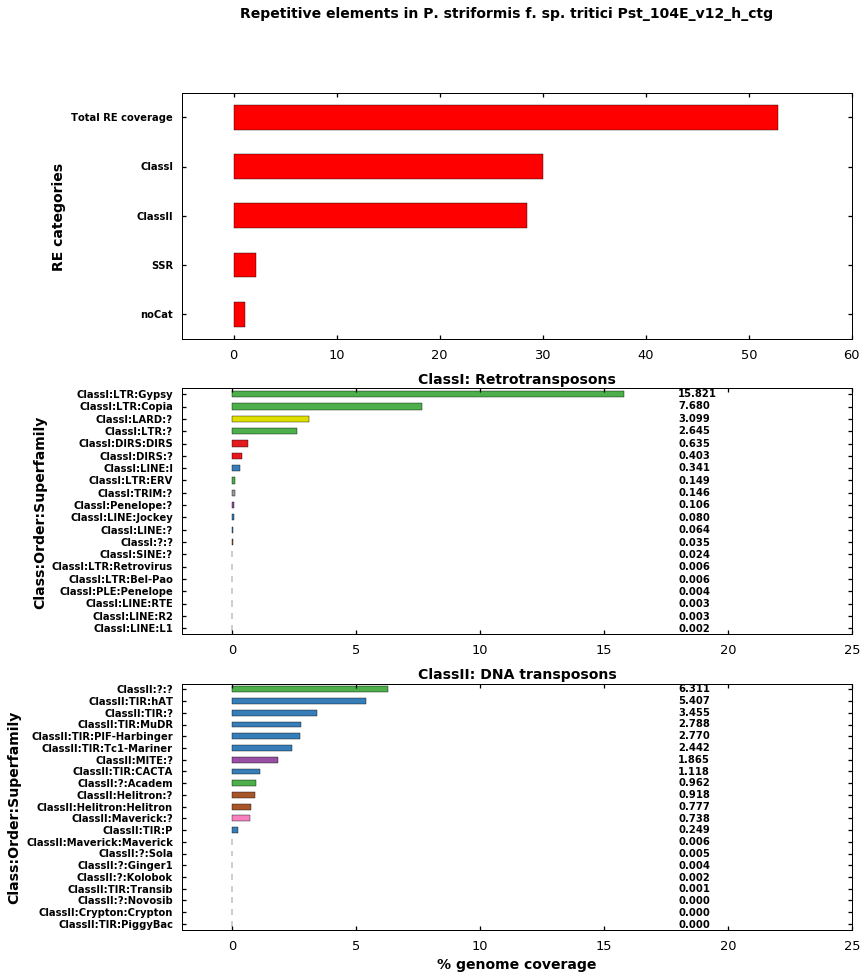

In [66]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in P. striformis f. sp. tritici %s" % genome, fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.plot(kind='barh', y='%', ax=ax0,  color='r')
ax0.set_xlim([-5,60])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%')

#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
classI_df.plot(kind='barh', y = '%', ax=ax1, color=classI_df['Color'])
ax1.set_xlim([-2,25])
ax1.legend().set_visible(False)
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['%']):
    ax1.annotate('{0:.3f}'.format(value), (18,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%')

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out
classII_df.plot(kind='barh', y = '%', ax=ax2, color=classII_df['Color'])
ax2.set_xlim([-2,25])
ax2.legend().set_visible(False)
ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('% genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['%']):
    ax2.annotate('{0:.3f}'.format(value), (18 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )
    
fig.savefig(genome+'.REPET_summary.seaborn-talk.png', dpi=600, bbox_inches="tight")

## Thats how far we got ##